# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [2]:
# class Transforms:
#     def __init__(self, transforms: A.Compose):
#         self.transforms = transforms

#     def __call__(self, img, *args, **kwargs):
#         return self.transforms(image=np.array(img))

In [3]:

a_train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16,
                    always_apply=False,
                    # fill_value=tuple(np.mean(datasets.CIFAR10(root='./data', train=True, download=True).data, axis=(0, 1)))),
                    fill_value=(0.5, 0.5, 0.5)),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

a_test_transforms = A.Compose([
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
])

# Dataset and Creating Train/Test Split

In [4]:
# from utils import get_mnist_data
# train, test = get_mnist_data(train_transforms, test_transforms)
def get_augmentation(transforms):
    return lambda img: transforms(image=np.array(img))['image']
train = datasets.CIFAR10('./data', train=True, download=True, transform=get_augmentation(a_train_transforms))
test = datasets.CIFAR10('./data', train=False, download=True, transform=get_augmentation(a_test_transforms))

100%|██████████| 170498071/170498071 [00:05<00:00, 29264991.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [6]:
import torch.nn.functional as F
dropout_value = 0.05
class Model_7(nn.Module):
    def __init__(self):
        super(Model_7, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False), #input 3x32x32 output 64x32x32 RF 3X3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),  #input 64x32x32 Output 128x32x32 RF 5X5
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, stride=2, bias=False),  #input 64x32x32 Output 128x32x32 RF 5X5
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding=1, bias=False), #input 128x32x32 Output 128x34x34 RF 5X5
        )

        # Block with 1 Dilation
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, dilation=2), #input 128x17x17 Output 128x15x15 RF 10X10
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=2, stride=2, bias=False), #input 128x15x15 Output 128x15x15 RF 18X18
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # Block with Depthwise separable Convolution
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1,groups=64), #input 128x7x7 Output 128x7x7 RF 38X38
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=1,stride=1,padding=0,groups=1), #input 128x7x7 Output 128x7x7 RF 38*38
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=2, stride =2, bias=False), #input 128x7x7 Output 128x9x9 RF 54X54
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False), #input 128x4x4 Output 128x6x6 RF 94X94
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1,  stride =1,bias=False), #input 128x6x6 Output 128x8x8 RF  126X126
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )
        self.gap = nn.AvgPool2d(kernel_size=5) #input 128x8x8 Output 128x1x1 RF  238X238
        self.output = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), #input 128x1x1 Output 64x1X1 RF 238X238
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), #input 64x1x1 Output 10x1x1 RF 238X238
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)+x
        x = self.gap(x)
        x = self.output(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_7().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
             ReLU-10           [-1, 32, 16, 16]               0
      BatchNorm2d-11           [-1, 32, 16, 16]              64
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 18, 18]           2,048
           Conv2d-14           [-1

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:
# from utils import train, test



from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
from torch.optim.lr_scheduler import StepLR

model =  Model_7().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.3678233623504639 Batch_id=390 Accuracy=34.28: 100%|██████████| 391/391 [00:24<00:00, 15.77it/s]



Test set: Average loss: 1.4431, Accuracy: 4654/10000 (46.54%)

EPOCH: 1


Loss=1.2824652194976807 Batch_id=390 Accuracy=46.13: 100%|██████████| 391/391 [00:25<00:00, 15.33it/s]



Test set: Average loss: 1.2244, Accuracy: 5579/10000 (55.79%)

EPOCH: 2


Loss=1.3180736303329468 Batch_id=390 Accuracy=51.40: 100%|██████████| 391/391 [00:24<00:00, 16.14it/s]



Test set: Average loss: 1.1032, Accuracy: 6080/10000 (60.80%)

EPOCH: 3


Loss=1.0962092876434326 Batch_id=390 Accuracy=55.50: 100%|██████████| 391/391 [00:22<00:00, 17.04it/s]



Test set: Average loss: 1.0565, Accuracy: 6238/10000 (62.38%)

EPOCH: 4


Loss=1.2461670637130737 Batch_id=390 Accuracy=58.55: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s]



Test set: Average loss: 0.9706, Accuracy: 6575/10000 (65.75%)

EPOCH: 5


Loss=1.298551082611084 Batch_id=390 Accuracy=61.01: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s]



Test set: Average loss: 0.8827, Accuracy: 6860/10000 (68.60%)

EPOCH: 6


Loss=1.024780035018921 Batch_id=390 Accuracy=62.81: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s]



Test set: Average loss: 0.8179, Accuracy: 7147/10000 (71.47%)

EPOCH: 7


Loss=1.1896693706512451 Batch_id=390 Accuracy=64.52: 100%|██████████| 391/391 [00:22<00:00, 17.01it/s]



Test set: Average loss: 0.7726, Accuracy: 7331/10000 (73.31%)

EPOCH: 8


Loss=1.0771454572677612 Batch_id=390 Accuracy=65.79: 100%|██████████| 391/391 [00:23<00:00, 16.63it/s]



Test set: Average loss: 0.7457, Accuracy: 7396/10000 (73.96%)

EPOCH: 9


Loss=0.6093679666519165 Batch_id=390 Accuracy=66.87: 100%|██████████| 391/391 [00:23<00:00, 16.35it/s]



Test set: Average loss: 0.7662, Accuracy: 7329/10000 (73.29%)

EPOCH: 10


Loss=0.9100130796432495 Batch_id=390 Accuracy=68.49: 100%|██████████| 391/391 [00:25<00:00, 15.05it/s]



Test set: Average loss: 0.7203, Accuracy: 7502/10000 (75.02%)

EPOCH: 11


Loss=0.8584879636764526 Batch_id=390 Accuracy=69.21: 100%|██████████| 391/391 [00:24<00:00, 16.13it/s]



Test set: Average loss: 0.6856, Accuracy: 7615/10000 (76.15%)

EPOCH: 12


Loss=0.6994466781616211 Batch_id=390 Accuracy=69.96: 100%|██████████| 391/391 [00:24<00:00, 16.06it/s]



Test set: Average loss: 0.6979, Accuracy: 7572/10000 (75.72%)

EPOCH: 13


Loss=0.7938230037689209 Batch_id=390 Accuracy=70.45: 100%|██████████| 391/391 [00:24<00:00, 16.16it/s]



Test set: Average loss: 0.6402, Accuracy: 7816/10000 (78.16%)

EPOCH: 14


Loss=0.8891793489456177 Batch_id=390 Accuracy=70.88: 100%|██████████| 391/391 [00:25<00:00, 15.12it/s]



Test set: Average loss: 0.6158, Accuracy: 7877/10000 (78.77%)

EPOCH: 15


Loss=0.8810718655586243 Batch_id=390 Accuracy=71.75: 100%|██████████| 391/391 [00:23<00:00, 16.57it/s]



Test set: Average loss: 0.6409, Accuracy: 7830/10000 (78.30%)

EPOCH: 16


Loss=0.7644339799880981 Batch_id=390 Accuracy=72.32: 100%|██████████| 391/391 [00:23<00:00, 16.98it/s]



Test set: Average loss: 0.5915, Accuracy: 7983/10000 (79.83%)

EPOCH: 17


Loss=0.6838676929473877 Batch_id=390 Accuracy=72.44: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s]



Test set: Average loss: 0.6120, Accuracy: 7882/10000 (78.82%)

EPOCH: 18


Loss=0.7035991549491882 Batch_id=390 Accuracy=72.84: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s]



Test set: Average loss: 0.5731, Accuracy: 8038/10000 (80.38%)

EPOCH: 19


Loss=0.5982687473297119 Batch_id=390 Accuracy=73.19: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s]



Test set: Average loss: 0.5667, Accuracy: 8076/10000 (80.76%)



In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.977177619934082 Batch_id=390 Accuracy=74.49: 100%|██████████| 391/391 [00:24<00:00, 16.00it/s]



Test set: Average loss: 0.5407, Accuracy: 8215/10000 (82.15%)

EPOCH: 1


Loss=0.7689520120620728 Batch_id=390 Accuracy=74.61: 100%|██████████| 391/391 [00:24<00:00, 16.13it/s]



Test set: Average loss: 0.5496, Accuracy: 8166/10000 (81.66%)

EPOCH: 2


Loss=0.4934121072292328 Batch_id=390 Accuracy=75.27: 100%|██████████| 391/391 [00:24<00:00, 16.15it/s]



Test set: Average loss: 0.5287, Accuracy: 8225/10000 (82.25%)

EPOCH: 3


Loss=0.635527491569519 Batch_id=390 Accuracy=75.33: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s]



Test set: Average loss: 0.5495, Accuracy: 8144/10000 (81.44%)

EPOCH: 4


Loss=0.5383815765380859 Batch_id=390 Accuracy=75.44: 100%|██████████| 391/391 [00:24<00:00, 16.11it/s]



Test set: Average loss: 0.5207, Accuracy: 8246/10000 (82.46%)

EPOCH: 5


Loss=0.6085028648376465 Batch_id=390 Accuracy=75.95: 100%|██████████| 391/391 [00:24<00:00, 16.06it/s]



Test set: Average loss: 0.5317, Accuracy: 8233/10000 (82.33%)

EPOCH: 6


Loss=0.47609829902648926 Batch_id=390 Accuracy=76.15: 100%|██████████| 391/391 [00:23<00:00, 16.62it/s]



Test set: Average loss: 0.5081, Accuracy: 8279/10000 (82.79%)

EPOCH: 7


Loss=0.5078985691070557 Batch_id=390 Accuracy=76.32: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s]



Test set: Average loss: 0.5127, Accuracy: 8315/10000 (83.15%)

EPOCH: 8


Loss=0.6016353964805603 Batch_id=390 Accuracy=76.29: 100%|██████████| 391/391 [00:23<00:00, 16.76it/s]



Test set: Average loss: 0.5001, Accuracy: 8301/10000 (83.01%)

EPOCH: 9


Loss=0.6028441190719604 Batch_id=390 Accuracy=76.58: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s]



Test set: Average loss: 0.4982, Accuracy: 8332/10000 (83.32%)



In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


EPOCHS = 10
for epoch in range(EPOCHS): v
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.6866176724433899 Batch_id=390 Accuracy=78.73: 100%|██████████| 391/391 [00:23<00:00, 16.79it/s]



Test set: Average loss: 0.4501, Accuracy: 8496/10000 (84.96%)

EPOCH: 1


Loss=0.7423050999641418 Batch_id=390 Accuracy=79.60: 100%|██████████| 391/391 [00:23<00:00, 16.39it/s]



Test set: Average loss: 0.4467, Accuracy: 8487/10000 (84.87%)

EPOCH: 2


Loss=0.37931013107299805 Batch_id=390 Accuracy=79.85: 100%|██████████| 391/391 [00:25<00:00, 15.19it/s]



Test set: Average loss: 0.4454, Accuracy: 8499/10000 (84.99%)

EPOCH: 3


Loss=0.5766041874885559 Batch_id=390 Accuracy=79.74: 100%|██████████| 391/391 [00:24<00:00, 16.08it/s]



Test set: Average loss: 0.4439, Accuracy: 8496/10000 (84.96%)

EPOCH: 4


Loss=0.7569453716278076 Batch_id=390 Accuracy=79.70: 100%|██████████| 391/391 [00:23<00:00, 16.41it/s]



Test set: Average loss: 0.4355, Accuracy: 8523/10000 (85.23%)

EPOCH: 5


Loss=0.5065914392471313 Batch_id=390 Accuracy=79.95: 100%|██████████| 391/391 [00:22<00:00, 17.05it/s]



Test set: Average loss: 0.4327, Accuracy: 8552/10000 (85.52%)

EPOCH: 6


Loss=0.6102321147918701 Batch_id=390 Accuracy=80.35: 100%|██████████| 391/391 [00:22<00:00, 17.54it/s]



Test set: Average loss: 0.4348, Accuracy: 8513/10000 (85.13%)

EPOCH: 7


Loss=0.5140649080276489 Batch_id=390 Accuracy=80.12: 100%|██████████| 391/391 [00:24<00:00, 16.08it/s]



Test set: Average loss: 0.4325, Accuracy: 8550/10000 (85.50%)

EPOCH: 8


Loss=0.5516524314880371 Batch_id=390 Accuracy=80.20: 100%|██████████| 391/391 [00:22<00:00, 17.16it/s]



Test set: Average loss: 0.4363, Accuracy: 8529/10000 (85.29%)

EPOCH: 9


Loss=0.5073819160461426 Batch_id=390 Accuracy=80.12: 100%|██████████| 391/391 [00:22<00:00, 17.30it/s]



Test set: Average loss: 0.4406, Accuracy: 8506/10000 (85.06%)



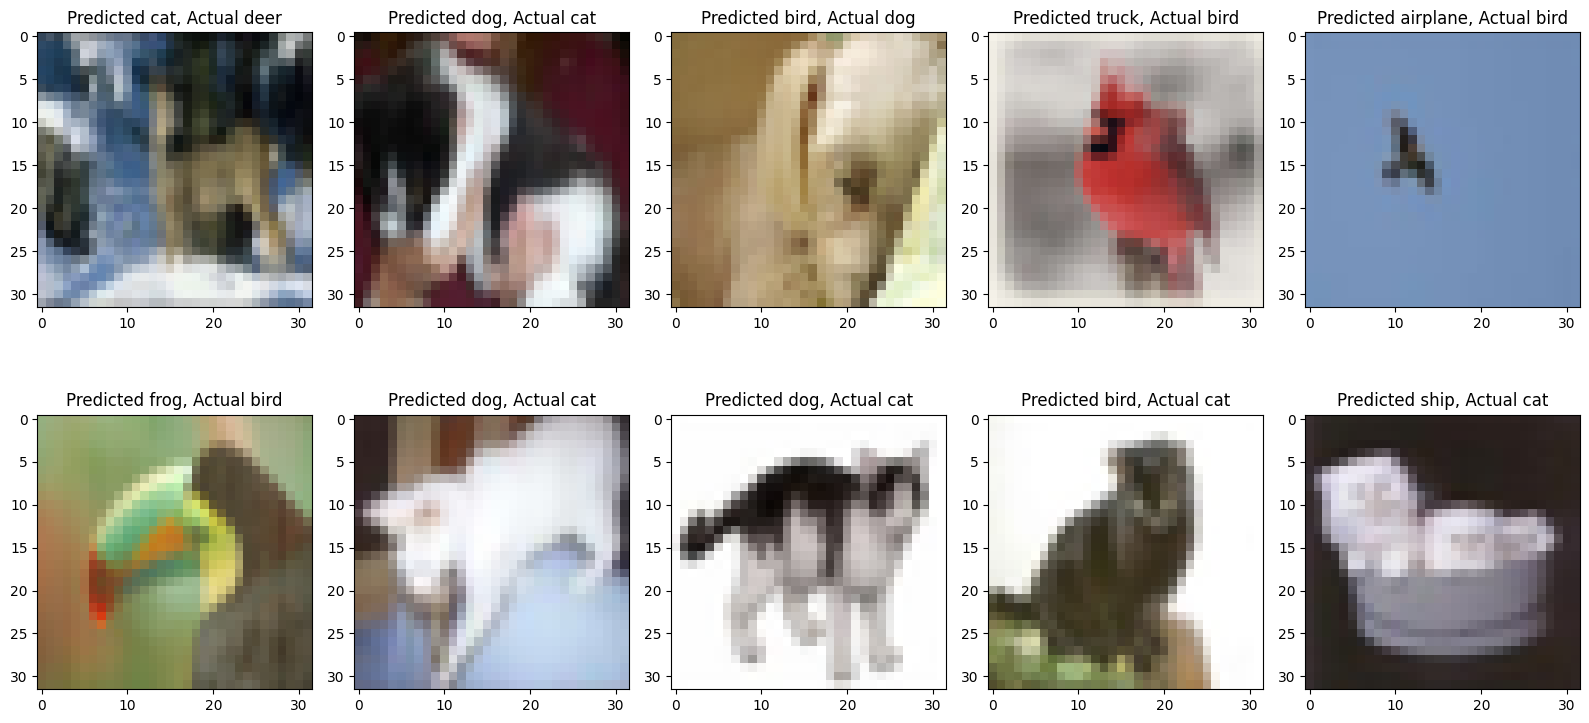

In [12]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_incorrect_images(model,test_loader,n=10):
  incorrect_images = []
  predicted_labels = []
  correct_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    incorrect_items = pred.ne(target.view_as(pred))
    incorrect_indices = incorrect_items.view(-1).nonzero().view(-1)
    predicted_labels.extend([item.item() for item in pred[incorrect_indices[:n-len(incorrect_images)]]])
    correct_labels.extend([item.item() for item in target.view_as(pred)[incorrect_indices[:n-len(incorrect_images)]]])
    incorrect_images.extend([item for item in data[incorrect_indices[:n-len(incorrect_images)]]])
    if len(incorrect_images)==n:
      break
  return incorrect_images,predicted_labels,correct_labels

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img
  npimg = np.clip(npimg, 0, 1)  # Add this line to clip the values
  return np.transpose(npimg, (1, 2, 0))  # Convert from Tensor image

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

incorrect_images,predicted_labels,correct_labels = get_incorrect_images(model,test_loader,n=10)

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    ax.imshow(imshow(image))  # Display the image
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()